**Model Training**
--

**Import Data and Required Packages**

**Importing Pandas, Numpy, Matplotlib, Seaborn and other Libraries**

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
import warnings

**Import the CSV Data as Pandas DataFrame**

In [2]:
df = pd.read_csv('data/Student_Performance.csv')

**5. Data Pre-Processing**
--

In [3]:
df.isna().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

**There are no missing values in the data set**

**5.1 Removing duplicates**
--

In [4]:
df.duplicated().sum()

np.int64(127)

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [6]:
df.info

<bound method DataFrame.info of       Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0                 7               99                        Yes            9   
1                 4               82                         No            4   
2                 8               51                        Yes            7   
3                 5               52                        Yes            5   
4                 7               75                         No            8   
...             ...              ...                        ...          ...   
9995              1               49                        Yes            4   
9996              7               64                        Yes            8   
9997              6               83                        Yes            8   
9998              9               97                        Yes            7   
9999              7               74                         No            8   

      S

**5.2 Splitting data into training and test sets**
--

**5.2.1 Corelation matrix**

In [7]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix["Performance Index"].sort_values(ascending=False)

Performance Index                   1.000000
Previous Scores                     0.915135
Hours Studied                       0.375332
Sleep Hours                         0.050352
Sample Question Papers Practiced    0.043436
Name: Performance Index, dtype: float64

**Insights:**
- The attribute that has the greatest impact on the performance index is “Previous results”, while less significant attributes are “Examples of exam tasks that have been completed” and “Hours of sleep”.

**5.2.2 To distribute the full dataset evenly across the two datasets, it is important to split the data into categories based on "Previous Scores"**

In [8]:
df["Previous Scores"].max()

np.int64(99)

<Axes: >

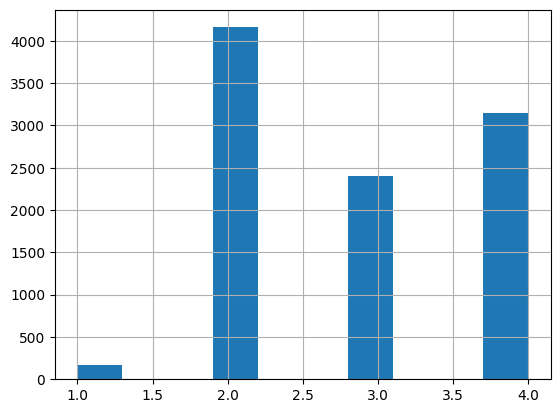

In [9]:
df["income_cat"] = pd.cut(df["Previous Scores"], bins=[0., 40., 65., 80., 100.], labels=[1,2,3,4])
df["income_cat"].hist()

**5.2.3 Performing stratified shuffle split based on Previous Results**

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

**Proportions of categories in test set**

In [11]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
2    0.421266
4    0.318481
3    0.243038
1    0.017215
Name: count, dtype: float64

**Deleting attribute "income_cat"**

In [12]:
strat_train_set = strat_train_set.drop("income_cat", axis=1)
strat_test_set = strat_test_set.drop("income_cat", axis=1)

**5.3 Preparing X and Y variables**
--

In [13]:
df = strat_train_set.drop("Performance Index", axis=1)
df_labels = strat_train_set["Performance Index"].copy()

**Processing categorical data**

In [14]:
df_cat = df[["Extracurricular Activities"]]
df_cat.head(5)

,Extracurricular Activities
6889,No
9588,Yes
2321,No
4898,No
2226,No


In [15]:
cat_encoder = OneHotEncoder()
df_cat_hot = cat_encoder.fit_transform(df_cat)
df_cat_hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7898 stored elements and shape (7898, 2)>

In [16]:
cat_encoder.categories_

[array(['No', 'Yes'], dtype=object)]

**5.4 Creating transformer**
--

**Adding columns for "Rest to Study Ratio" and "Effort on Top of Knowledge"**

In [17]:
hours_studied, previous_scores, sleep_hours = 0, 1, 3
class CombinedAttributesAdder(BaseEstimator, TransformerMixin) :
    def __init__(self, add_rest_to_study = True):
        self.add_rest_to_study = add_rest_to_study
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        effort = X[:, previous_scores] * X[:, hours_studied]
        if self.add_rest_to_study:
            rest_to_study = X[:, sleep_hours] / X[:, hours_studied]
            return np.c_[X, effort, rest_to_study]
        else:
            return np.c_[X, effort]
attr_adder = CombinedAttributesAdder(add_rest_to_study=False)
df_extra_attribs = attr_adder.transform(df.values)